In [1]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [2]:
from code_programm.path import get_path_weight_model

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

1
NVIDIA GeForce GTX 1080 Ti


In [4]:
# model = YOLO(get_path_model('yolov8s-seg.pt'))

In [5]:
# model = YOLO(get_path_model('yolov8n-seg.pt'))

In [6]:
model = YOLO(get_path_weight_model('best_v2_n.pt'))
# model = YOLO(get_path_weight_model('yolov8s-seg_v3.pt'))

In [7]:
img = cv2.imread(r'C:\PycharmProjects\ETS_Autopilot\static\settings_cache\1708818112.041754.png')
print(img.shape)

(500, 500, 3)


In [8]:
results = model(img, imgsz=512, conf=0.75, verbose=True, show=True, device='cpu')

0: 512x512 3 markups, 2 markup_lines, 283.0ms
Speed: 8.0ms preprocess, 283.0ms inference, 37.0ms postprocess per image at shape (1, 3, 512, 512)


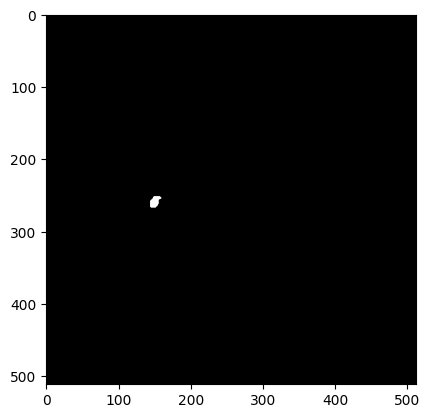

In [23]:
plt.imshow(results[0].masks.data[3].cpu().numpy(), 'gray')

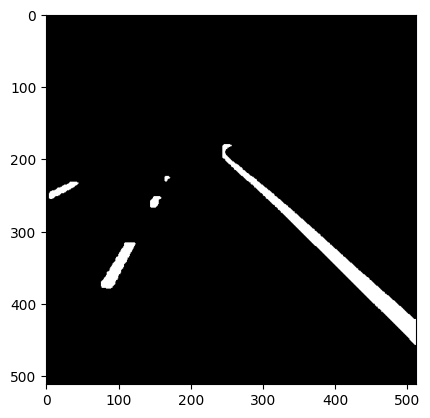

In [26]:
import numpy as np


size = 512
# Создание пустого массива для хранения объединенных масок
combined_mask = np.zeros((size, size))

# Перебор всех масок
for i in results[0].masks.data:
    # Добавление каждой маски к объединенному массиву
    combined_mask += i.cpu().numpy()

# Преобразование объединенного массива в тип uint8
combined_mask.astype(np.uint8)
# Сохранение объединенного массива в файл
plt.imshow(combined_mask, 'gray')

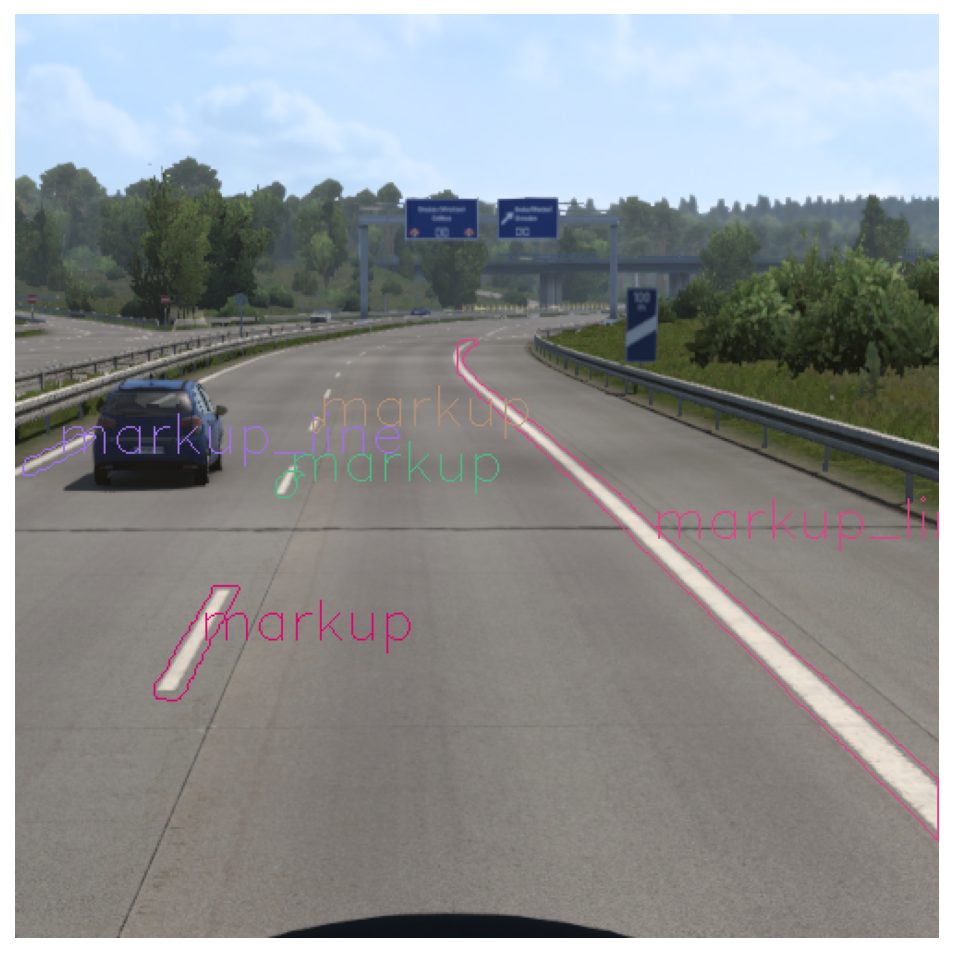

In [19]:
# Получение классов и имен классов
classes = results[0].boxes.cls.cpu().numpy()
class_names = results[0].names

# Получение бинарных масок и их количество
masks = results[0].masks.data  # Формат: [число масок, высота, ширина]
num_masks = masks.shape[0]

# Определение случайных цветов и прозрачности для каждой маски
colors = [tuple(np.random.randint(0, 256, 3).tolist()) for _ in range(num_masks)]  # Случайные цвета

# Создание изображения для отображения масок
mask_overlay = np.zeros_like(img)

labeled_image = img.copy()

# Добавление подписей к маскам
for i in range(num_masks):
    color = colors[i]  # Случайный цвет
    mask = masks[i].cpu()

    # Изменение размера маски до размеров исходного изображения с использованием метода ближайших соседей
    mask_resized = cv2.resize(np.array(mask), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Получение класса для текущей маски
    class_index = int(classes[i])
    class_name = class_names[class_index]

    # Добавление подписи к маске
    mask_contours, _ = cv2.findContours(mask_resized.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(labeled_image, mask_contours, -1, color, 1)
    cv2.putText(labeled_image, class_name,
                (int(mask_contours[0][:, 0, 0].mean()), int(mask_contours[0][:, 0, 1].mean())),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1)

# Отобразите итоговое изображение с наложенными масками и подписями
plt.figure(figsize=(8, 8), dpi=150)
labeled_image = cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB)
plt.imshow(labeled_image)
plt.axis('off')
plt.savefig('output.png')
plt.show()

In [12]:
import os

path = r'C:\PycharmProjects\ETS_Autopilot\static\datasets\validation\images'

for filename in os.listdir(path):
    if filename.endswith('.png'):
        try:
            image_path = os.path.join(path, filename)
            # Загрузка изображения
            img = cv2.imread(image_path)
            results = model(img, imgsz=512, conf=0.65, verbose=True)
            # Получение классов и имен классов
            classes = results[0].boxes.cls.cpu().numpy()
            class_names = results[0].names

            # Получение бинарных масок и их количество
            masks = results[0].masks.data  # Формат: [число масок, высота, ширина]
            num_masks = masks.shape[0]

            # Определение случайных цветов и прозрачности для каждой маски
            colors = [tuple(np.random.randint(0, 256, 3).tolist()) for _ in range(num_masks)]  # Случайные цвета

            # Создание изображения для отображения масок
            mask_overlay = np.zeros_like(img)

            labeled_image = img.copy()

            # Добавление подписей к маскам
            for i in range(num_masks):
                color = colors[i]  # Случайный цвет
                mask = masks[i].cpu()

                # Изменение размера маски до размеров исходного изображения с использованием метода ближайших соседей
                mask_resized = cv2.resize(np.array(mask), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

                # Получение класса для текущей маски
                class_index = int(classes[i])
                class_name = class_names[class_index]

                # Добавление подписи к маске
                mask_contours, _ = cv2.findContours(mask_resized.astype(np.uint8), cv2.RETR_EXTERNAL,
                                                    cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(labeled_image, mask_contours, -1, color, 1)
                cv2.putText(labeled_image, class_name,
                            (int(mask_contours[0][:, 0, 0].mean()), int(mask_contours[0][:, 0, 1].mean())),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1)

            # Отобразите итоговое изображение с наложенными масками и подписями
            plt.figure(figsize=(8, 8), dpi=150)
            labeled_image = cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB)
            plt.imshow(labeled_image)
            plt.axis('off')
            plt.savefig(
                os.path.join('C:\\PycharmProjects\\ETS_Autopilot\\static\\settings_cache\\frames', f'{filename}'))
            plt.clf()
        except InterruptedError:
            print('User interrupted')

0: 512x512 3 markups, 2 markup_lines, 109.0ms
Speed: 2.0ms preprocess, 109.0ms inference, 8.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 1 markup, 1 markup_line, 98.0ms
Speed: 1.0ms preprocess, 98.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 markups, 2 markup_lines, 102.0ms
Speed: 2.0ms preprocess, 102.0ms inference, 12.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 markups, 2 markup_lines, 117.0ms
Speed: 1.0ms preprocess, 117.0ms inference, 6.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 markups, 2 markup_lines, 132.0ms
Speed: 2.0ms preprocess, 132.0ms inference, 6.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 markups, 2 markup_lines, 112.0ms
Speed: 1.0ms preprocess, 112.0ms inference, 7.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 markups, 2 markup_lines, 108.0ms
Speed: 2.0ms preprocess, 108.0ms inference, 5.0ms postprocess per image at shape (1, 3, 512, 

C:\Users\filip\AppData\Local\Temp\ipykernel_7944\4082468480.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8), dpi=150)


0: 512x512 2 markups, 2 markup_lines, 108.1ms
Speed: 1.0ms preprocess, 108.1ms inference, 6.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 markups, 2 markup_lines, 101.0ms
Speed: 1.0ms preprocess, 101.0ms inference, 6.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 2 markups, 2 markup_lines, 109.0ms
Speed: 2.0ms preprocess, 109.0ms inference, 6.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 markups, 2 markup_lines, 135.0ms
Speed: 1.0ms preprocess, 135.0ms inference, 5.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 4 markups, 2 markup_lines, 138.0ms
Speed: 1.0ms preprocess, 138.0ms inference, 7.0ms postprocess per image at shape (1, 3, 512, 512)


KeyboardInterrupt: 

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

In [56]:
import cv2

# Загрузить видео
video_path = r'C:\PycharmProjects\ETS_Autopilot\static\settings_cache\cropped_video_4.mp4'
cap = cv2.VideoCapture(video_path)

# Зациклить по кадрам
while True:
    ret, frame = cap.read()
    detections = model.predict(frame, imgsz=512, conf=0.65, show=True)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

0: 512x512 2 markup_lines, 162.0ms
Speed: 2.0ms preprocess, 162.0ms inference, 11.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 2 markup_lines, 476.2ms
Speed: 15.0ms preprocess, 476.2ms inference, 5.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 2 markup_lines, 116.0ms
Speed: 1.0ms preprocess, 116.0ms inference, 4.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 2 markup_lines, 119.7ms
Speed: 2.0ms preprocess, 119.7ms inference, 4.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 2 markup_lines, 113.0ms
Speed: 1.0ms preprocess, 113.0ms inference, 4.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 2 markup_lines, 100.0ms
Speed: 2.0ms preprocess, 100.0ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 2 markup_lines, 103.0ms
Speed: 2.0ms preprocess, 103.0ms inference, 4.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 2 markup_lines, 110.0ms
Speed: 1.0ms preprocess, 110.0ms

KeyboardInterrupt: 

In [16]:
import cv2

# Путь к сохраненному видео
video_path = r'C:\PycharmProjects\ETS_Autopilot\app\static\settings_cache\cropped_video_4.mp4'

# Загрузить видео
cap = cv2.VideoCapture(video_path)

# Зациклить по кадрам
while True:
    # Считать кадр
    ret, frame = cap.read()

    # Отобразить кадр
    cv2.imshow("YOLO", frame)

    # Завершить цикл при нажатии клавиши
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [1]:
# Выходной путь для видео
output_path = "output.mp4"

# Кодек для видео
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Размер кадра
width = frame.shape[1]
height = frame.shape[0]

# Создать объект VideoWriter
writer = cv2.VideoWriter(output_path, fourcc, 30.0, (width, height))

# Записать кадры в видео
while True:
    # Обработать кадр с помощью YOLO
    detections = model.predict(frame, imgsz=512, conf=0.65, show=True)

    # Записать кадр
    writer.write(frame)

    # Завершить цикл при нажатии клавиши
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Закрыть VideoWriter
writer.release()

NameError: name 'cv2' is not defined